In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import numpy as np

In [2]:
df = pd.read_pickle('../results/results.pkl')

In [17]:
def get_rows(
    args_dict,
):
    idx = {}
    for key, value in args_dict.items():
        if value is None:
            idx[key] = np.ones_like(df[key], dtype=bool)
        else:
            idx[key] = df[key] == value
        
    run_idx = np.ones_like(df['test_loss'], dtype=bool)
    for key, value in idx.items():
        run_idx = run_idx & value
    
    # print(f"Selected {run_idx.sum()} runs!")
    
    run_df = df[run_idx].reset_index(drop=True)   
    return run_df

def get_loss(
    args_dict,
):
    run_df = get_rows(args_dict)

    rank_set = np.unique(run_df['rank'])
    seed_set = np.unique(run_df['seed'])
    metric, metric_median = {}, {}
    mtc_l = ['test_loss', 'test_acc', 'test_shift_acc']
    output = {}
    
    for method in ['sgd', 'ours']:
        group_df = run_df[run_df['method'] == method].reset_index(drop=True)   
        for mtc in mtc_l:
            metric[mtc], metric_median[mtc] = {}, {}

            for rank in rank_set:
                rank_df = group_df[group_df['rank'] == rank].reset_index(drop=True)
                metric[mtc][rank] = {}
                for seed in seed_set:
                    seed_df = rank_df[rank_df['seed'] == seed].reset_index(drop=True)   
                    
                    if method == 'sgd':     
                        min_loss_index = seed_df['val_loss'].idxmin()
                        row_with_min_loss = seed_df.loc[min_loss_index]
                        metric[mtc][rank][seed] = row_with_min_loss[mtc]
                    elif method == 'ours':
                        metric[mtc][rank][seed] = seed_df[mtc].iloc[-1]
                    else:
                        raise ValueError('method must be sgd or ours')
                metric_median[mtc][rank] = pd.Series(metric[mtc][rank]).median()
            
            metric_median[mtc] = pd.Series(metric_median[mtc])
        output[method] = pd.DataFrame({mtc: metric_median[mtc] for mtc in mtc_l})
    return output

In [18]:

activation = 'relu'
use_bias = 1
width = 16
exp = 'fnn'
init_mode = 'default'
target_depth = 2
frozen_depth = 4
pretrained = 0


for target_depth in [1,2]:
    fnn_results = get_loss({
        'activation': activation,
        'use_bias': use_bias,
        'target_depth': target_depth,
        'frozen_depth': frozen_depth,
        'init_mode': init_mode,
        'width': width,
        'exp': exp,
        'pretrained': pretrained,
        'tune_bias': 1,
        'rank_step': 0,
        'task': 'classification',
    })
    


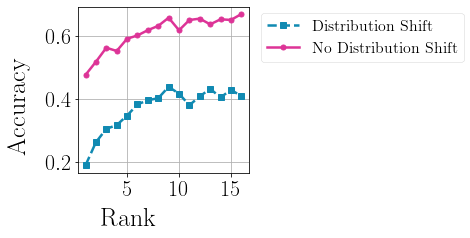

In [19]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

sgd_marker, sgd_color, sgd_lt, sgd_ms = 's', '#118AB2', '--', 6
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
lw = 2.5

fig, ax = plt.subplots(nrows=1, ncols=1, sharey = True)
fig.subplots_adjust(left=0.3, bottom=.24, right=0.98, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(3.5, 3.5) #exact size of the figure

# fnn_results['test_loss'].plot(ax = ax, color = sgd_color, label = 'Distribution Shift', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)

fnn_results['sgd']['test_shift_acc'].plot(ax = ax, color = sgd_color, label = 'Distribution Shift', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)
fnn_results['sgd']['test_acc'].plot(ax = ax, color = our_color, label = 'No Distribution Shift', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms)
ax.grid(True)

ax.legend(fontsize=16, bbox_to_anchor=(1.02,1.01))
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('Accuracy', fontsize = 26)
    
plt.savefig('../figures/in_out_dist.pdf')
# Show the plot
plt.show()

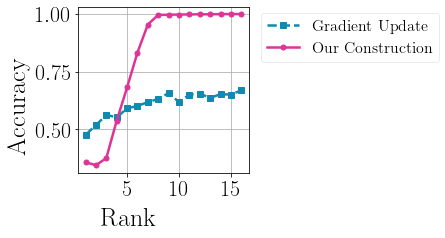

In [20]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

sgd_marker, sgd_color, sgd_lt, sgd_ms = 's', '#118AB2', '--', 6
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
lw = 2.5

fig, ax = plt.subplots(nrows=1, ncols=1, sharey = True)
fig.subplots_adjust(left=0.3, bottom=.24, right=0.98, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(3.5, 3.5) #exact size of the figure

# fnn_results['test_loss'].plot(ax = ax, color = sgd_color, label = 'Distribution Shift', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)

fnn_results['sgd']['test_acc'].plot(ax = ax, color = sgd_color, label = 'Gradient Update', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)
fnn_results['ours']['test_acc'].plot(ax = ax, color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms)
ax.grid(True)

ax.legend(fontsize=16, bbox_to_anchor=(1.02,1.01))
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('Accuracy', fontsize = 26)
    
plt.savefig('../figures/classification.pdf')
# Show the plot
plt.show()

In [86]:
get_loss({
    'activation': activation,
    'use_bias': use_bias,
    'target_depth': target_depth,
    'frozen_depth': frozen_depth,
    'init_mode': init_mode,
    'width': width,
    'exp': exp,
    'pretrained': pretrained,
    'tune_bias': 1,
    'rank_step': 0,
    'task': 'classification',
})

,test_loss,test_bin_acc,test_shift_bin_acc
1,-3.985157e+19,0.9990,0.9370
2,-3.882804e+15,0.9756,0.8996
3,-1.487400e+19,0.9640,0.8466
4,-1.215645e+22,0.9896,0.9104
5,-9.090042e+21,0.7542,0.7028
6,-1.363436e+23,0.9990,0.9650
7,-2.748766e+23,0.9916,0.8430
8,-3.208602e+23,0.9786,0.7312
9,-3.384678e+23,0.7848,0.7780
10,1.174514e+00,0.9990,0.9716


In [79]:
get_rows({
    'activation': activation,
    'use_bias': use_bias,
    'target_depth': target_depth,
    'frozen_depth': frozen_depth,
    'init_mode': init_mode,
    'width': width,
    'exp': exp,
    'pretrained': pretrained,
    'tune_bias': 1,
    'rank_step': 0,
    'task': 'classification',
    'method': 'sgd',
})[['rank', 'test_shift_acc', 'test_acc', 'test_loss']]

,rank,test_shift_bin_acc,test_bin_acc,test_loss
0,14,0.8394,0.8178,-5.025945e+23
1,13,0.5016,0.5072,-2.030870e+09
2,13,0.5016,0.5072,-2.007491e+09
3,13,0.5016,0.5072,-4.866392e+23
4,13,0.5016,0.5072,-4.866587e+23
...,...,...,...,...
951,2,0.6950,0.7410,-2.068441e+12
952,2,0.6870,0.7150,-1.652447e+12
953,1,0.8776,0.9634,-1.774918e+04
954,1,0.8776,0.9634,-1.867824e+04


In [82]:
fnn_results

,test_loss,test_bin_acc,test_shift_bin_acc
1,-3.985157e+19,0.9990,0.9370
2,-3.882804e+15,0.9756,0.8996
3,-1.487400e+19,0.9640,0.8466
4,-1.215645e+22,0.9896,0.9104
5,-9.090042e+21,0.7542,0.7028
6,-1.363436e+23,0.9990,0.9650
7,-2.748766e+23,0.9916,0.8430
8,-3.208602e+23,0.9786,0.7312
9,-3.384678e+23,0.7848,0.7780
10,1.174514e+00,0.9990,0.9716


In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example parameters
input_size = 10
hidden_size = 5
num_classes = 3

# Create an instance of SimpleMLP
model = SimpleMLP(input_size, hidden_size, num_classes)

# Dummy input
input_tensor = torch.randn(1, input_size)

# Forward pass
output = model(input_tensor)

# Use torch.max to get the predicted class
_, predicted_class = torch.max(output.data, 1)

print("Output scores:", output)
print("Predicted class:", predicted_class)


Output scores: tensor([[-0.1210, -0.2770,  0.3324]], grad_fn=<AddmmBackward0>)
Predicted class: tensor([2])
